In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
import random

plt.style.use("dark_background")
df=pd.read_csv("ETHUSDT_1h.csv").iloc[::-1]
# df["timestamp"] = pd.to_datetime(df["timestamp"])
plt.subplots_adjust(hspace=5)

<Figure size 640x480 with 0 Axes>

In [12]:
# CHOOSING A RANDOM SEQUENCE OF THE CHART

length = df.shape[0]
backtesting_length = 3000
random_indx = random.randrange(backtesting_length, length - backtesting_length - 1)
df = df.iloc[random_indx:random_indx+backtesting_length]


In [ ]:
# STRATEGY SETTINGS

# For example, buying if under ema100 and selling when over it, with each 200 usd space from max and min
buy_data = []
sell_data = []
# RSI BASED
OVERSOLD = 10
OVERBOUGHT = 90

# MACD BASED
MACD_OVER = 60
MACD_UNDER = -60

def calcRSI(avg_gain, avg_loss):
    if avg_loss == 0: return 100
    rs = avg_gain / avg_loss
    return 100 - (100 / (1 + rs))

df["change"] = df["close"].diff()
df["gain"]=df["change"].clip(lower=0)
df["loss"]=-df["change"].clip(upper=0)
df["avggain"]=df["gain"].rolling(12).mean()
df["avgloss"]=df["loss"].rolling(12).mean()
df["RSI"]=df.apply(lambda r: calcRSI(r['avggain'], r["avgloss"]), axis=1)

# ----- EMA STRAT
EMA=100
ema_data = df.ewm(span=EMA, adjust=False).mean()
df["macd"] = (df["close"].ewm(span=12, adjust=False).mean() - df["close"].ewm(span=26, adjust=False).mean())
min = 70
max = 100
# for _, row in df.iterrows():
#     if row["timestamp"] and row['close']:
#         ema_close = ema_data["close"].at[row.name]
#         if row["close"] < ema_close - max:
#             buy_data.append([row["timestamp"], row["close"]])
#         elif row["close"] > ema_close + min:
#             sell_data.append([row["timestamp"], row["close"]])


# ------- RSI STRAT
# for _, row in df.iterrows():
#     if not pd.notna(row["RSI"]):
#         continue
#     timestamp = row["timestamp"]
#     price = row["close"]
#     rsi = row["RSI"]
#     if rsi < OVERSOLD:
#         buy_data.append([timestamp, price])
#     elif rsi > OVERBOUGHT:
#         sell_data.append([timestamp, price])


#       COMBINED
# for _, row in df.iterrows():
#     if row["timestamp"] and row['close']:
#         if not pd.notna(row["RSI"]):
#            continue
        
#         timestamp = row["timestamp"]
#         price = row["close"]
#         rsi = row["RSI"]
#         ema_close = ema_data["close"].at[row.name]
#         if row["close"] < ema_close - max and rsi < OVERSOLD:
#             buy_data.append([row["timestamp"], row["close"]])
#         elif row["close"] > ema_close + min and rsi > OVERBOUGHT:
#             sell_data.append([row["timestamp"], row["close"]])

# MACD
for _, row in df.iterrows():
    macd_val = row.get("macd")
    if pd.isna(macd_val):
        continue
    timestamp = row.get("timestamp")
    price = row.get("close")
    if pd.isna(timestamp) or pd.isna(price):
        continue
    if macd_val < MACD_UNDER:
        buy_data.append([timestamp, price])
    elif macd_val > MACD_OVER:
        sell_data.append([timestamp, price])
    
BUY_SIGNAL = pd.DataFrame(buy_data, columns=["Timestamp", "Price"])
SELL_SIGNAL = pd.DataFrame(sell_data, columns=["Timestamp", "Price"])

In [14]:
buys = []

# Now we have to check if the row has a timestamp in the BUY_SIGNAL dataframe
# If so, update the balance amount by 10
money = 10000 # Giving myself 10K
imoney = money
asset = 0 # I own 0 ETH at first
buy_amount = 0.1
sell_amount = 0.1
for _, row in df.iterrows():
    # If theres a BUY_SIGNAL at this timestamp increase asset by 0.1 * asset price
    if row["timestamp"] in BUY_SIGNAL["Timestamp"].values:
        if(money>=buy_amount*row["close"]):
            asset += buy_amount
            money -= buy_amount*row["close"]
            print("BOUGHT ETH FOR "+str(buy_amount))
    if row["timestamp"] in SELL_SIGNAL["Timestamp"].values:
        if(asset>=sell_amount):
            asset -= sell_amount
            money += sell_amount*row["close"]
            print("SOLD ETH FOR "+str(sell_amount))
    
    buys.append({"balance": money+(asset*row["close"])})
    # print("BALANCE: "+str(money))
PORTFOLIO = pd.DataFrame(buys)
print("TOTAL PnL: "+str(round((PORTFOLIO["balance"].iloc[-1])-imoney, 2))+"$")

TOTAL PnL: 0.0$


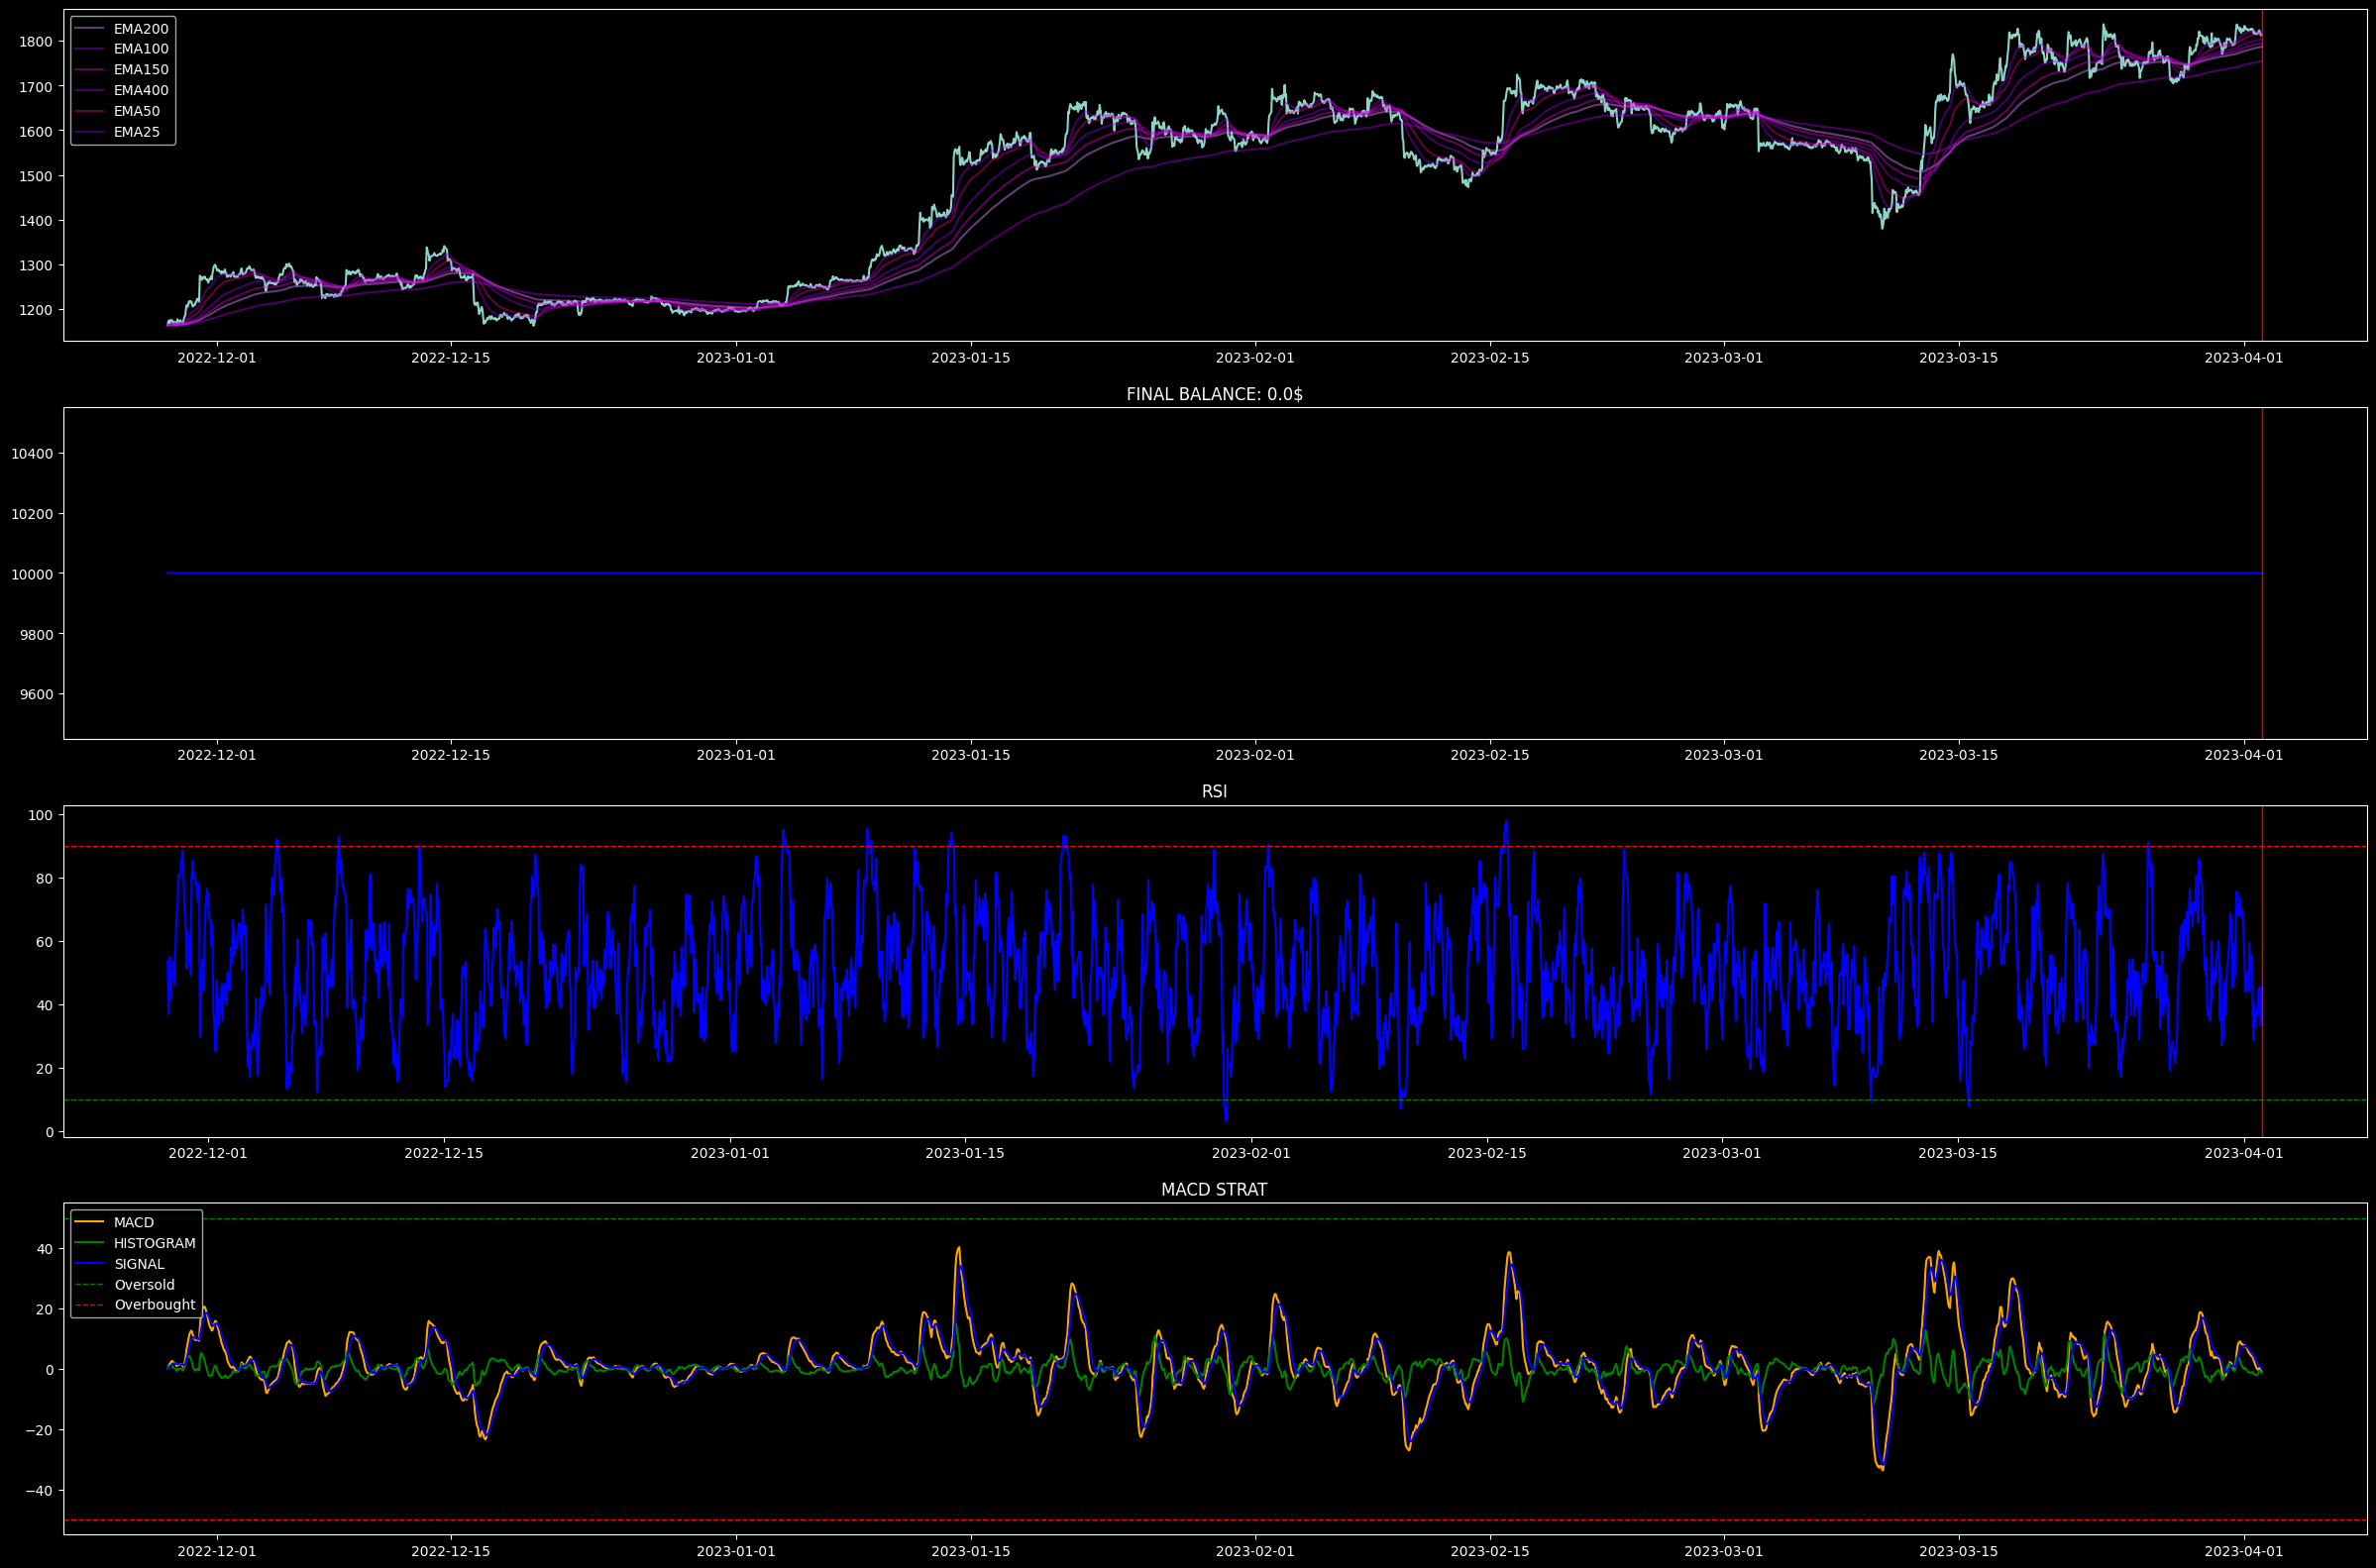

In [15]:
# DISPLAYING



#CONVERT TIMESTAMPS
df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms').astype('datetime64[s]')
BUY_SIGNAL['Timestamp'] = pd.to_datetime(BUY_SIGNAL['Timestamp'], unit='ms').astype('datetime64[s]')
SELL_SIGNAL['Timestamp'] = pd.to_datetime(SELL_SIGNAL['Timestamp'], unit='ms').astype('datetime64[s]')
x1 = df['timestamp']
y1 = df["close"]

#EMA LINES
ema25 = y1.ewm(span=25, adjust=False).mean()
ema50 = y1.ewm(span=50, adjust=False).mean()
ema100 = y1.ewm(span=100, adjust=False).mean()
ema150 = y1.ewm(span=150, adjust=False).mean()
ema200 = y1.ewm(span=200, adjust=False).mean()
ema400 = y1.ewm(span=400, adjust=False).mean()

# MACD
MACD_line = (y1.ewm(span=12, adjust=False).mean() - y1.ewm(span=26, adjust=False).mean())
MACD_sign = MACD_line.ewm(span=9, adjust=False).mean()
MACD_line_hist = MACD_line - MACD_sign

fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(30, 20))
plt.subplots_adjust(hspace=0.2)

ax1.plot(x1,y1)
ax1.axvline(x=df['timestamp'].iloc[-1], color="red", linestyle="-", linewidth=1)
ax1.plot(x1, ema200, color="#d284ff78", linewidth=1.5, label="EMA200")
ax1.plot(x1, ema100, color="#a200ff65", linewidth=1.5, label="EMA100")
ax1.plot(x1, ema150, color="#ff00f264", linewidth=1.5, label="EMA150")
ax1.plot(x1, ema400, color="#c300ff63", linewidth=1.5, label="EMA400")
ax1.plot(x1, ema50, color="#ff009d64", linewidth=1.5, label="EMA50")
ax1.plot(x1, ema25, color="#a200ff63", linewidth=1.5, label="EMA25")
ax1.legend(loc="upper left")
ax1.scatter(BUY_SIGNAL["Timestamp"], BUY_SIGNAL["Price"] - 25, color="#00FF0073", s=50, marker="^", zorder=5)
ax1.scatter(SELL_SIGNAL["Timestamp"], SELL_SIGNAL["Price"] + 25, color="#ff101065", s=50, marker="v", zorder=5)

# PORTFOLIO BALANCE
x2 =  df["timestamp"]
y2 =  PORTFOLIO["balance"]
ax2.plot(x2,y2,  color="blue")
ax2.set_title("FINAL BALANCE: "+str(round((PORTFOLIO["balance"].iloc[-1])-imoney, 2))+"$")
ax2.axvline(x=df['timestamp'].iloc[-1], color="red", linestyle="-", linewidth=1)


# RSI
ax3.plot(x2,df["RSI"],  color="blue")
ax3.set_title("RSI")
ax3.axhline(y=OVERSOLD, color="green", linestyle="--", linewidth=1, label="Oversold")
ax3.axhline(y=OVERBOUGHT, color="red", linestyle="--", linewidth=1, label="Overbought")
ax3.axvline(x=df['timestamp'].iloc[-1], color="red", linestyle="-", linewidth=1)


# MACD PLOT
ax4.plot(x2, MACD_line, color="orange", label="MACD")
ax4.plot(x2, MACD_line_hist, color="green", label="HISTOGRAM")
ax4.plot(x2, MACD_sign, color="blue", label="SIGNAL")
ax4.set_title("MACD STRAT")
ax4.axhline(y=50, color="green", linestyle="--", linewidth=1, label="Oversold")
ax4.axhline(y=-50, color="red", linestyle="--", linewidth=1, label="Overbought")
ax4.legend(loc="upper left")

plt.show()